The goals of this lab are:
- to look at the variabilty of a $k$-fold cross-validation
- to use cross-validation to select a parameter
- to work with rebalanced dataset as well as custom metrics

In [1]:
import numpy as np

import polars as pl
import polars.selectors as cs

import seaborn as sns
import seaborn.objects as so

import sklearn
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
GERMAN_CREDIT_LINK = "https://raw.githubusercontent.com/IBM/monitor-wml-model-with-watson-openscale/master/data/german_credit_data_biased_training.csv"
german_credit = pl.read_csv(GERMAN_CREDIT_LINK)

In [3]:
string_columns = german_credit.select(cs.string()).columns
numerical_columns = german_credit.select(cs.numeric()).columns

categorical_features = string_columns.copy()
categorical_features.remove('Risk')
categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_columns)
        ],
        remainder='passthrough',
        force_int_remainder_cols=False
    )

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier())]).set_output(transform="polars")

pipeline_log = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression())]).set_output(transform="polars")

We need then to prepare the testing set as well the training one.

In [4]:
X = german_credit.drop('Risk')
y = german_credit['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cross validation and variability

A basic $5$-fold cross validation is performed using

In [5]:
cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

array([0.78   , 0.76375, 0.7625 , 0.76875, 0.76875])

It can be intersting to store those results in a Polar Dataframe to easily compute some derived metrics afterward :

In [6]:
res = pl.DataFrame(
    dict(
        name='nn5',
        score=cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    )
)

In [7]:
res

name,score
str,f64
"""nn5""",0.78
"""nn5""",0.76375
"""nn5""",0.7625
"""nn5""",0.76875
"""nn5""",0.76875


**Question** Why are those 5 accuracy values not identical?

**Answer** For each repetiton, the training and validation set are different, so the trained predictor is different. So the empirical accuracy is different.

**Question** What is average accuracy? What is the variance?

In [8]:
print(f'The average accuracy is {res["score"].mean()}')
print(f'The variance is {res["score"].var():.3e}')

The average accuracy is 0.76875
The variance is 4.766e-05


Remember that the default cross validation is a stratified one wihout shuffling and thus that it can reproduced by:

In [9]:
cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')

array([0.78   , 0.76375, 0.7625 , 0.76875, 0.76875])

**Question** What happens if one repeat the same experience 5 times using `shuffle=True, random_state=i` where $i$ is the number of the repetitions with

In [10]:
res = pl.DataFrame()
for i in range(5):
    res = pl.concat(
        [
            res,
            pl.DataFrame(dict(
                name='nn5',
                rep=i,
                fold=range(5),
                score=cross_val_score(
                    pipeline, X_train, y_train,
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
                    scoring='accuracy'
                )
            ))
        ]
    )

**Question** Compare the scores between the nearest neighbor classifier and the logistic one.

In [11]:
res = pl.concat(
    [
        (
            pl.DataFrame(dict(
                name='nn5',
                rep=i,
                fold=range(5),
                score=cross_val_score(
                    pipeline, X_train, y_train,
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
                    scoring='accuracy'
                )
            ))
        ) for i in range(5)
    ] + [
        (
            pl.DataFrame(dict(
                name='logit',
                rep=i,
                fold=range(5),
                score=cross_val_score(
                    pipeline_log, X_train, y_train,
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=i),
                    scoring='accuracy'
                )
            ))
        ) for i in range(5)
    ]
)

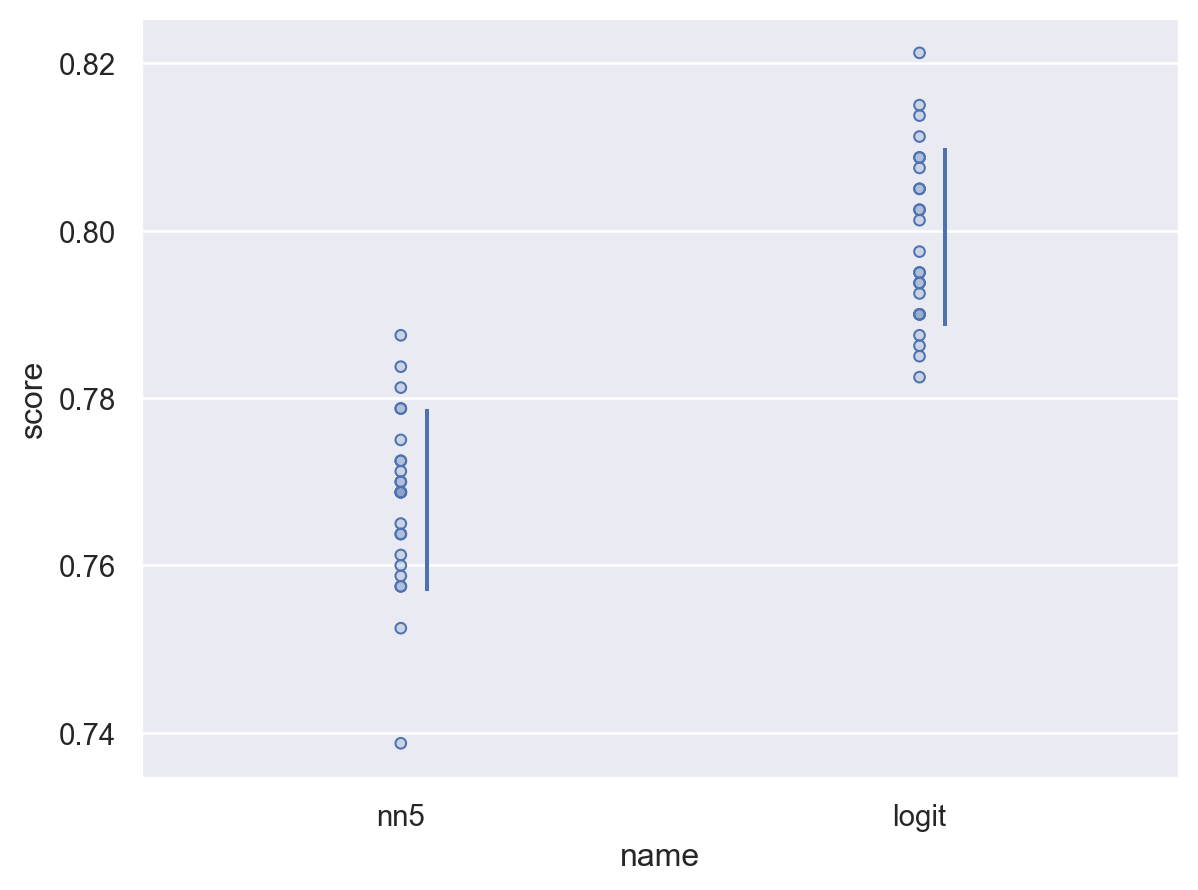

In [12]:
(
    so.Plot(data=res, x="name", y="score")
    .add(so.Dots())
    .add(so.Range(), so.Est(errorbar='sd'), so.Shift(x=.05))
)

**Answer** The logistic regression outperforms the k-NN classifier with $k=5$

So far we have used the standard deviation:

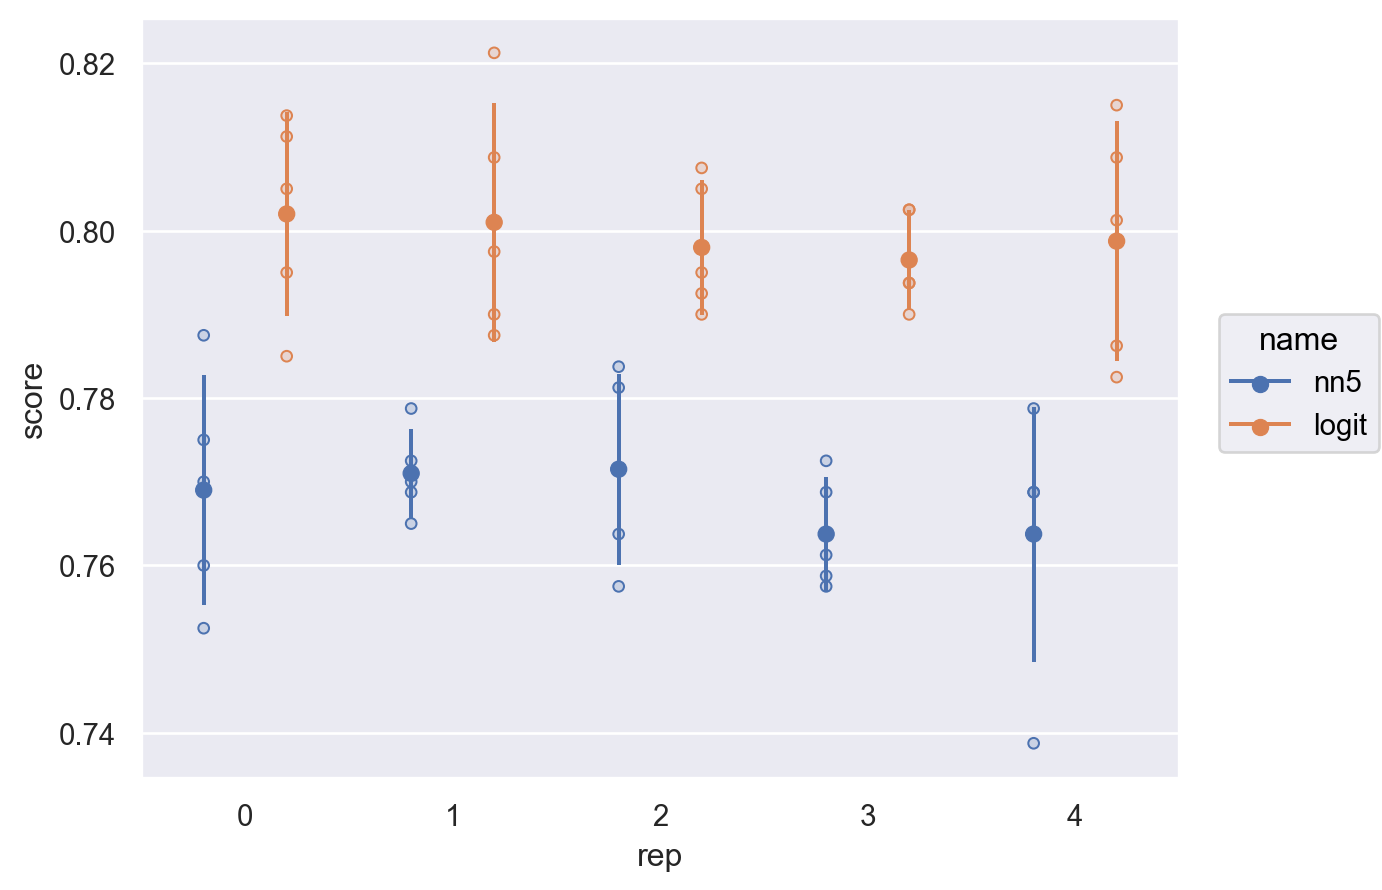

In [13]:
(so.Plot(res, x='rep', y='score', color='name')
 .add(so.Dots(),so.Dodge())
 .add(so.Dot(),so.Agg(),so.Dodge())
 .add(so.Range(), so.Est(errorbar="sd"),so.Dodge())
 .scale(x=so.Nominal())
)

but we would also use the standard error (the standard deviation divided by the square root of the number of repetions):

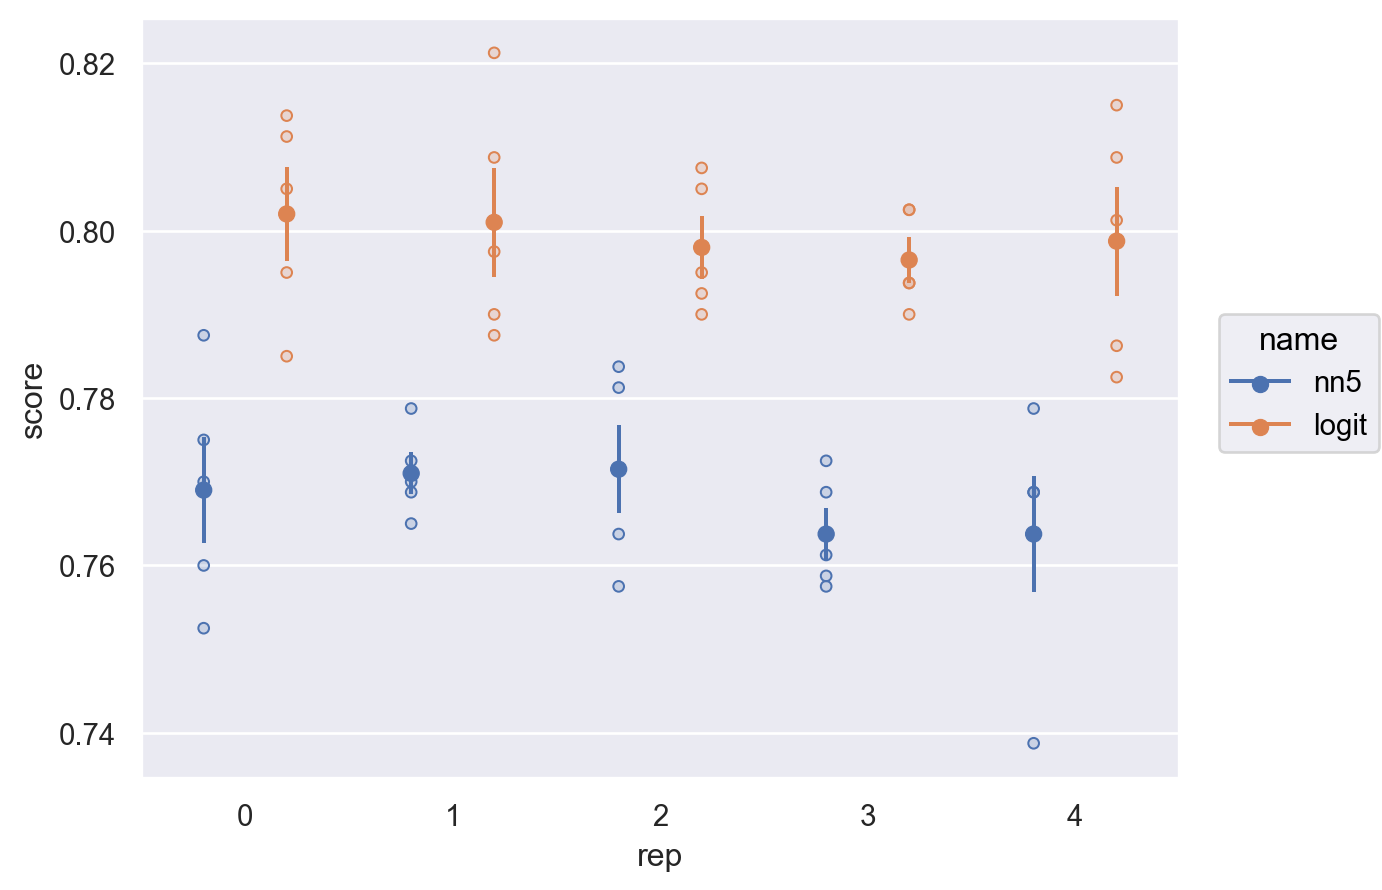

In [14]:
(so.Plot(res, x='rep', y='score', color='name')
 .add(so.Dots(),so.Dodge())
 .add(so.Dot(),so.Agg(),so.Dodge())
 .add(so.Range(), so.Est(errorbar="se"),so.Dodge())
 .scale(x=so.Nominal())
)

### Fine-tuning of neighbors

**Question** Find the "best" number of neighbors using cross validation. You can restrict yourself to the following values:

In [15]:
n_neighbors_values = [3, 5, 7, 11, 15, 19, 25, 31, 37, 47, 57, 67, 90, 150, 300, 600]

Note that the best model could be the one with the larger average accuracy, the one with the larger lower confidence value of the accuracy ot its mean, or even the simpler model whose average could be as large as the best average accuracy.

In [16]:
def pipeline_k_neighbors(k: int):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ]).set_output(transform="polars")

res = pl.concat([
    (
        pl.DataFrame(dict(
            n_neighbors=k,
            fold=range(10),
            score=cross_val_score(
                pipeline_k_neighbors(k), X_train, y_train,
                cv=10,
                scoring='accuracy'
            )
        ))
    ) for k in n_neighbors_values
])

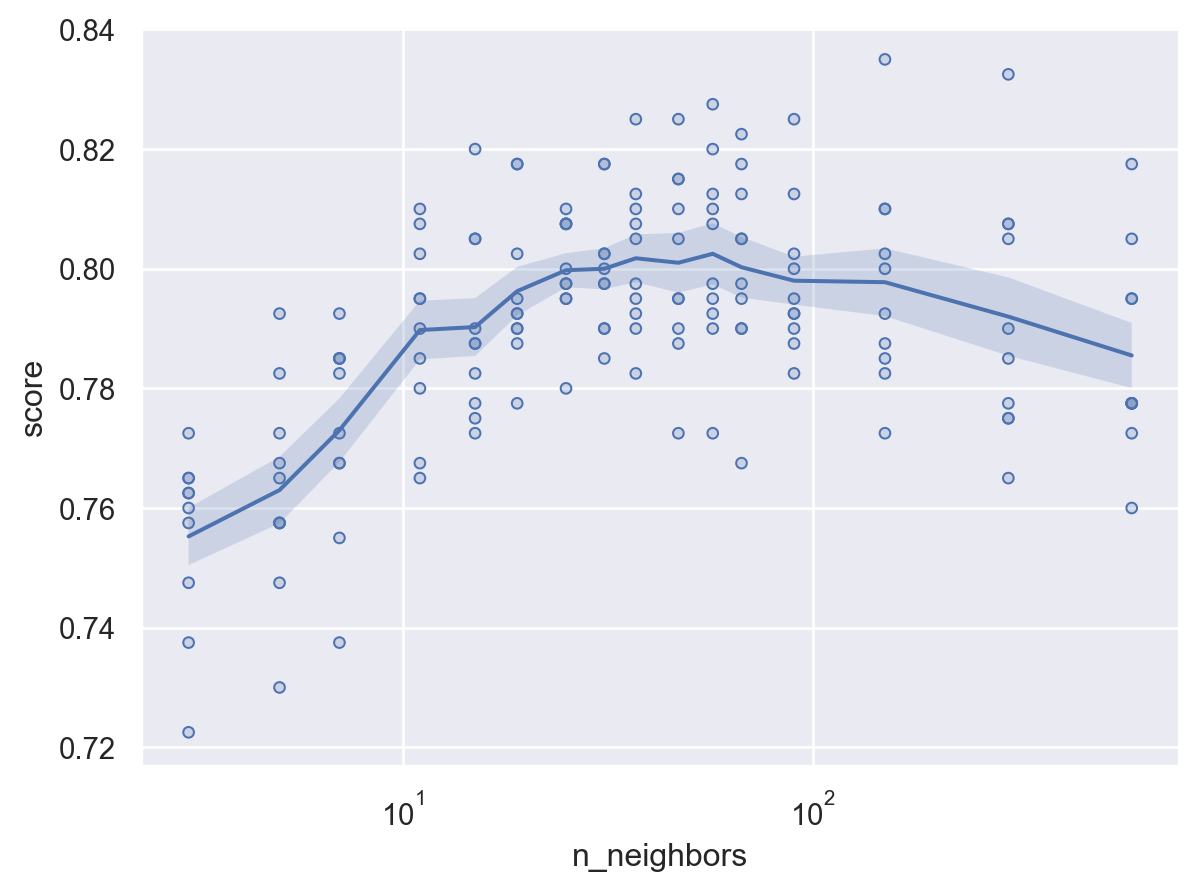

In [17]:
(
    so.Plot(res, x='n_neighbors', y='score')
    .add(so.Dots(), so.Dodge())
    .add(so.Line(), so.Agg(), so.Dodge())
    .add(so.Band(), so.Est(errorbar='se'))
    .scale(x='log')
)

The best average value is obtained with $k=57$, but this accuracy is in the standard error interval of the model with $k=25$. There is no significant difference in accuracy between these two models. However, the latter takes significantly less time to make prediction.

## Learning with weights and cost

Assume now that we know than in the realworld the proportion of `Risk`is $.02$, which is much smaller than we have in our dataset. We could try to adapt our process to take this information into account.

A first step is to define a new custom metric (and its corresponding scorer) to estimate the accuracy in the real world. This can be done as follows:

In [18]:
real_prop = {'Risk': .02, 'No Risk': .98}
train_prop = {'Risk': 1/3, 'No Risk': 2/3}
custom_weight = {
    'Risk': real_prop['Risk']/train_prop['Risk'], 
    'No Risk': real_prop['No Risk']/train_prop['No Risk']
}

def custom_metric(y_true, y_pred):
  loss = (custom_weight['Risk']*(y_true=='Risk')+custom_weight['No Risk']*(y_true=='No Risk')) *\
    (pl.Series(y_pred) != y_true)
  return(1-loss.mean())

custom_scorer = make_scorer(custom_metric)

If we use the Logistic regression (and refit it to be sure), we can compute its accuracy:

In [19]:
pipeline_log.fit(X_train, y_train)
custom_scorer(pipeline_log, X_test, y_test)

0.88606

We verify easily that this accuracy is different from the one obtain with the usual metric:

In [20]:
accuracy_scorer = make_scorer(accuracy_score)
accuracy_scorer(pipeline_log, X_test, y_test)

0.793

**Question** Is this a good score?

**Answer** No, the accuracy is only better because the class on which the model is less accurate were underrepresented. But the model stays the same. A better predictor should be obtained if we use those weights during training.

In [21]:
sklearn.set_config(enable_metadata_routing=False)

def compute_weights(y_true):
    return(custom_weight['Risk']*(y_true=='Risk')+custom_weight['No Risk']*(y_true=='No Risk'))

pipeline_log_weighted = clone(pipeline_log)
pipeline_log_weighted.fit(X_train, y_train, classifier__sample_weight=compute_weights(y_train))
custom_scorer(pipeline_log_weighted, X_test, y_test)

0.98023

We are indeed much better than with the original predictor.

A second approach is to use the probability estimated in the dataset world and to modify the decision to take into account the proportions.

In [22]:
def custom_predict_from_proba(proba: float):
    decision = np.vstack([
        proba[:,0] *  custom_weight['No Risk'],
        proba[:,1] *  custom_weight['Risk']
    ])
    return pl.Series(pipeline_log.classes_[decision.argmax(axis=0)])

def custom_predict(pipeline, X_test):
    proba = pipeline.predict_proba(X_test)
    return custom_predict_from_proba(proba)

In [23]:
y_pred = custom_predict(pipeline_log, X_test)
custom_metric(y_test, y_pred)

0.98074

which is very similar.

Note that to use a scorer function, one has to do a little hack:

In [24]:
def custom_predict_from_single_proba(proba):
    proba = np.column_stack((1.0-proba, proba))
    return custom_predict_from_proba(proba)

def custom_metric_from_proba(y_true, proba):
    y_pred = custom_predict_from_single_proba(proba)
    return custom_metric(y_true, y_pred)

custom_scorer_from_proba = make_scorer(custom_metric_from_proba, response_method="predict_proba")

custom_scorer_from_proba(pipeline_log, X_test, y_test)

0.98074

It turns out that the accuracy is probably not the best way to measure the quality of such a predictor. Indeed the cost of such a prediction depends on the predictio, the real outcome... and the amount of the loan.

A possible cost model could be:
- $5.0 + .5 \times \text{LoanAmount}$ if we predict `No Risk` and there was a `Risk` (default), as we may lose a lot of money to process those issues.
- $1.0 - .1 \times \text{LoanAmount}$ if we predict `No Risk` and there was a indeed `No Risk` (default), if we assume that the expected benefit is $.1 \times \text{LoanAmount}$ after an initial cost of $1$.
- $1$ if we predict `Risk`, as noting is going to happen after the refusal.

This could be encoded in the following metric:

In [25]:
def compute_costs(LoanAmount):
    return({
        'Risk_No Risk': 5.0 + .5 * LoanAmount, 
        'No Risk_No Risk': 1.0 - .1 * LoanAmount,
        'Risk_Risk': 1.0, 
        'No Risk_Risk': 1.0
    })

def custom_metric(y_true, y_pred, LoanAmount):
    costs = compute_costs(LoanAmount)
    y_pred = pl.Series(y_pred)

    loss = (
        (y_true=='Risk') * custom_weight['Risk'] * (y_pred=='Risk') * costs['Risk_Risk']
        + (y_true=='Risk') * custom_weight['Risk'] * (y_pred=='No Risk') * costs['Risk_No Risk']
        + (y_true=='No Risk') * custom_weight['No Risk'] * (y_pred=='Risk') * costs['No Risk_Risk']
        + (y_true=='No Risk') * custom_weight['No Risk'] * (y_pred=='No Risk') * costs['No Risk_No Risk']
    )

    return loss.mean()

In [26]:
sklearn.set_config(enable_metadata_routing=True)

custom_scorer = make_scorer(custom_metric, greater_is_better=False).set_score_request(LoanAmount=True)

In [27]:
LoanAmount = X['LoanAmount']

X_train, X_test, y_train, y_test, LoanAmount_train, LoanAmount_test = train_test_split(X, y, LoanAmount, test_size=0.2, random_state=42)

custom_scorer(pipeline_log, X_test, y_test, LoanAmount=LoanAmount_test)

195.96103500000004

Note that this value corresponds to the opposite of the expected average cost due to the use of the option `reater_is_better=False`.

**Question** Can you find a better predictor for this metric?

**Answer** 

The cost matrix is :

| True Label \ Predicted Label | Risk | No-Risk |
| :-- | :-- | :-- |
| Risk | $1$ | $5+0.5\times L$ |
| No-Risk | $1$ | $1-0.1\times L$ |

with $L$ the Loan Amount.

We could set training weights for training data, taking into account the misclassification cost, which is $4+0.5\times L$ if `Risk` and $0.1 \times L$ if `No Risk`.

In [28]:
sklearn.set_config(enable_metadata_routing=False)

def compute_weights(risk, loan_amount):
    return (
        (risk == 'Risk') * (4 + .5 * loan_amount) * custom_weight['Risk']
        + (risk == 'No Risk') * (.1 * loan_amount) * custom_weight['No Risk']
    )

LoanAmount = X['LoanAmount']
X_train, X_test, y_train, y_test, LoanAmount_train, LoanAmount_test = train_test_split(X, y, LoanAmount, test_size=0.2, random_state=42)

weights = compute_weights(y_train, LoanAmount_train)

pipeline_log_weighted = clone(pipeline_log)
pipeline_log_weighted.fit(X_train, y_train, classifier__sample_weight=weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CheckingStatus',
                                                   'CreditHistory',
                                                   'LoanPurpose',
                                                   'ExistingSavings',
                                                   'EmploymentDuration', 'Sex',
                                                   'OthersOnLoan',
                                                   'OwnsProperty',
                                                   'InstallmentPlans',
                                                   'Housing', 'Job',
                                                   'Telephone',
                                                   'ForeignWorker']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LoanDuration', 'LoanAmount',
                                                   'InstallmentPercent',
                                                   'CurrentResidenceDuration',
                                                   'Age',
                                                   'ExistingCreditsCount',
                                                   'Dependents'])])),
                ('classifier', LogisticRegression())])

In [29]:
sklearn.set_config(enable_metadata_routing=True)

custom_scorer(pipeline_log_weighted, X_test, y_test, LoanAmount=LoanAmount_test)

229.40474700000001